In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [42]:
#!pip install seaborn

In [50]:
url = '30MQA_1/fqFiltered.txt'
df = pd.read_csv(url, sep="\t", header=None)

In [51]:
df.columns = ['url1', 'url2', 'url3', 'question']

In [53]:
df.head()

,url1,url2,url3,question
0,<http://rdf.freebase.com/ns/m.04whkz5>,www.freebase.com/book/written_work/subjects,<http://rdf.freebase.com/ns/m.01cj3p>,what is the book e about ?
1,<http://rdf.freebase.com/ns/m.0tp2p24>,www.freebase.com/music/release_track/release,<http://rdf.freebase.com/ns/m.0sjc7c1>,in what release does the release track cardiac...
2,<http://rdf.freebase.com/ns/m.04j0t75>,www.freebase.com/film/film/country,<http://rdf.freebase.com/ns/m.07ssc>,what country is the debt from ?
3,<http://rdf.freebase.com/ns/m.0ftqr>,www.freebase.com/music/producer/tracks_produced,<http://rdf.freebase.com/ns/m.0p600l>,what songs have nobuo uematsu produced ?
4,<http://rdf.freebase.com/ns/m.036p007>,www.freebase.com/music/release/producers,<http://rdf.freebase.com/ns/m.0677ng>,who produced eve-olution ?


In [12]:
df1 = df[['url2', 'question']]
df1.head()

,url2,question
0,www.freebase.com/book/written_work/subjects,what is the book e about ?
1,www.freebase.com/music/release_track/release,in what release does the release track cardiac...
2,www.freebase.com/film/film/country,what country is the debt from ?
3,www.freebase.com/music/producer/tracks_produced,what songs have nobuo uematsu produced ?
4,www.freebase.com/music/release/producers,who produced eve-olution ?


In [62]:
len(df)

19809224

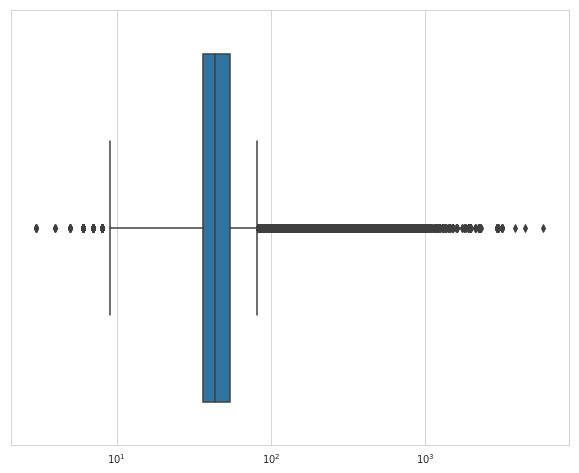

In [71]:
df2 = pd.DataFrame(len_question)
df2.columns = ['len']
plt.figure(figsize=(10,8))
sns.boxplot(df2)
plt.xscale('log')

<Figure size 720x576 with 0 Axes>

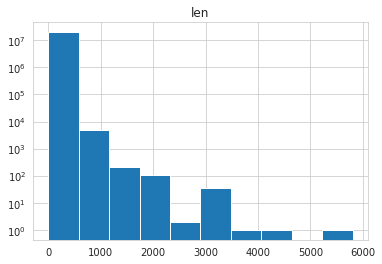

In [75]:
plt.figure(figsize=(10,8))
df2.hist()
plt.yscale('log')

#### check the maximum length of questions

In [63]:
len_question = [len(x) for x in df1['question']]
print(max(len_question))


5803


## make a dataset only with questions

In [15]:
questions = pd.DataFrame(df1['question'])
print(len(questions))
questions[:10]

19809224


,question
0,what is the book e about ?
1,in what release does the release track cardiac...
2,what country is the debt from ?
3,what songs have nobuo uematsu produced ?
4,who produced eve-olution ?
5,which artist recorded most of us are sad ?
6,what movie is produced by warner bros. enterta...
7,what is don graham known as ?
8,what is an attraction near columbus ?
9,what album was tibet released on ?


In [16]:
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table

def save_table_as_fig(df, filename):
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111, frame_on=False) # no visible frame
    ax.xaxis.set_visible(False)  # hide the x axis
    ax.yaxis.set_visible(False)  # hide the y axis

    table(ax, df, loc='upper right')  # where df is your data frame

    plt.savefig(filename, dpi=100)

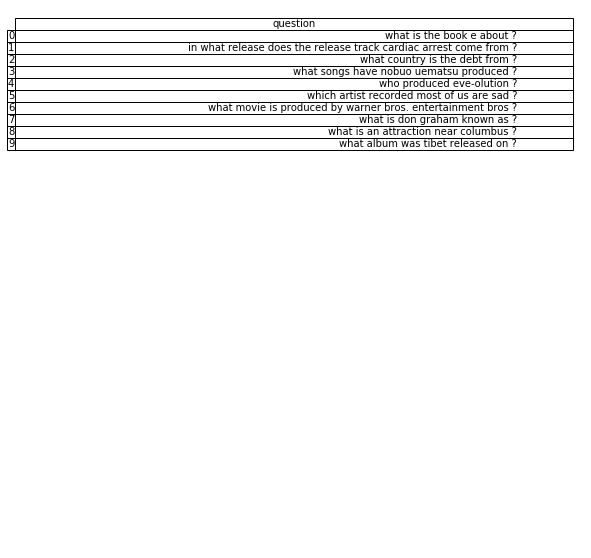

In [17]:
df = questions[:10]

save_table_as_fig(df, 'mytable.png')

## Text preprocessing:

#### install NLTK for word tokenization

In [325]:
#!pip install nltk

In [18]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/mariam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
import re
from nltk.tokenize import WhitespaceTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
def preprocessing(question):
    new_question = []
    question = WhitespaceTokenizer().tokenize(question)  #tokenize by white space, I also tried word tokenize but it gives a very bad result when using NER and POS
    for word in question:
        w = re.sub(r'[^\w\s\"$<>]','',word) #remove everything except words and space, we also keep $, <, > to identify pos and ner tagging in a string
        w = WordNetLemmatizer().lemmatize(w)                            
        new_question.append(w)
    return new_question

In [22]:
preprocessing('how to properly use "farther" and "further" in a sentence?')

['how',
 'to',
 'properly',
 'use',
 '"farther"',
 'and',
 '"further"',
 'in',
 'a',
 'sentence']

## Select a subset of the new dataset in order to fit it in the memory 

In [76]:
ind = np.random.choice(len(questions), len(questions)-3000, replace=False)
train_data = questions.drop(ind, axis=0)
len(train_data)

3000

## Install Flair

In [24]:
#!pip install flair

## Import Flair library 

In [25]:
from flair.data import Sentence

from flair.models import SequenceTagger
# make a sentence


## Define the different classes of word we that matter

In [26]:
meaningful_pos = ['<NN>', '<NNS>', '<NNP>','<NNPS>',                #Nouns
                 '<PRP$>',                                #Pronouns
                  '<JJ>' , '<JJR>', '<JJS>' ,                        ##adjective
                  '<RB>', '<RBS>', '<RBR>',                         #Adverbe
                 '<VB>', '<VBD>','<VBG>', 'VBN>', '<VBZ>','<VBP>',  #Verbs
                 '<IN>', '<CD>',                            ##conjunction-subordinating(before, after, on), cardinal number(five, four)
                 '<FW>',                                    ##foreign words
                 '<MD>']                                   ##Modal (Can,  may)                  

In [27]:
def get_ner(question):
    # load the NER tagger
    tagger_ner = SequenceTagger.load('ner-fast')  ## Use ner-fast ecause we are not running on GPU
    sent = Sentence(question)
    tagger_ner.predict(sent)
    s = sent.to_tagged_string()
    se = preprocessing(s)
    ner = []
    #print(se)
    for i in range(len(se)-1):
        if se[i+1] and se[i+1][0] and se[i+1][0] == '<':
            ner.append(se[i])
    return ner


#### Run NER on the 10 first question (for time purpose)

2019-06-12 14:13:41,943 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 14:13:44,284 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 14:13:45,720 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 14:13:47,226 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 14:13:48,568 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 14:13:49,890 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 14:13:51,215 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 14:13:52,577 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 14:13:53,894 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 14:13:55,026 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt


,question,ner
0,what is the book e about ?,[]
1,in what release does the release track cardiac...,[]
2,what country is the debt from ?,[]
3,what songs have nobuo uematsu produced ?,[]
4,who produced eve-olution ?,[]
5,which artist recorded most of us are sad ?,[]
6,what movie is produced by warner bros. enterta...,[]
7,what is don graham known as ?,[]
8,what is an attraction near columbus ?,[]
9,what album was tibet released on ?,[]


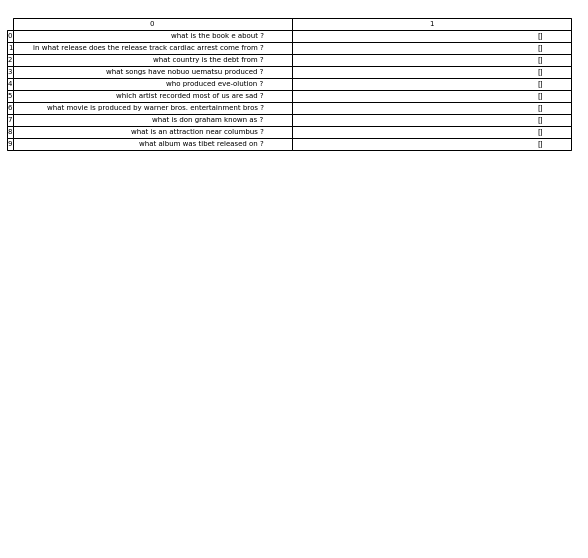

In [28]:
ner = []
for question in df['question']:
    #print(get_ner(question))
    ner.append((question,get_ner(question)))
ner = pd.DataFrame(ner)
save_table_as_fig(ner, 'ner.svg')
ner.columns = ['question', 'ner']
ner

In [29]:
def get_pos(question):
    ##load POS tagger
    tagger_ner = SequenceTagger.load('pos-fast')  ##use pos-fast see that we are not running on GPU
    sent = Sentence(question)
    tagger_ner.predict(sent)
    s = sent.to_tagged_string()
    return s


#### Run POS on the 10 first question (for time purpose)

2019-06-12 14:14:14,283 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 14:14:14,912 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 14:14:15,160 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 14:14:15,346 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 14:14:15,552 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 14:14:15,723 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 14:14:15,928 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 14:14:16,167 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 14:14:16,367 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 14:14:16,556 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt


,question,pos
0,what is the book e about ?,what <WP> is <VBZ> the <DT> book <NN> e <NN> a...
1,in what release does the release track cardiac...,in <IN> what <WP> release <NN> does <VBZ> the ...
2,what country is the debt from ?,what <WDT> country <NN> is <VBZ> the <DT> debt...
3,what songs have nobuo uematsu produced ?,what <WDT> songs <NNS> have <VBP> nobuo <FW> u...
4,who produced eve-olution ?,who <WP> produced <VBD> eve-olution <NN> ? <.>
5,which artist recorded most of us are sad ?,which <WDT> artist <NN> recorded <VBD> most <J...
6,what movie is produced by warner bros. enterta...,what <WDT> movie <NN> is <VBZ> produced <VBN> ...
7,what is don graham known as ?,what <WP> is <VBZ> don <NN> graham <NN> known ...
8,what is an attraction near columbus ?,what <WP> is <VBZ> an <DT> attraction <NN> nea...
9,what album was tibet released on ?,what <WP> album <NN> was <VBD> tibet <NN> rele...


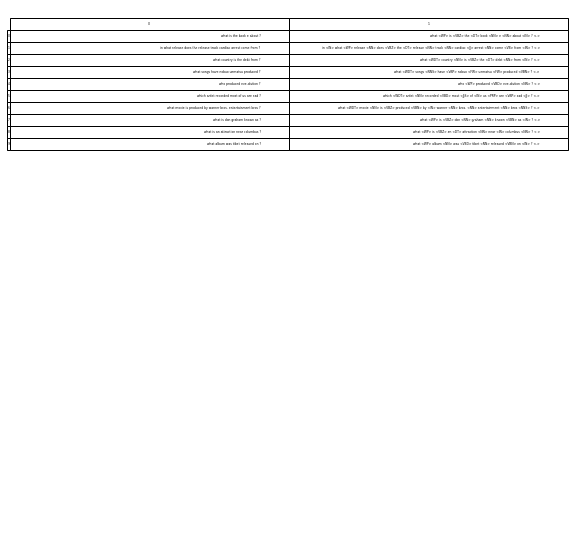

In [30]:
pos = []
for question in df['question']:
    #print(get_ner(question))
    pos.append((question,get_pos(question)))
pos = pd.DataFrame(pos)
save_table_as_fig(pos, 'pos.svg')
pos.columns = ['question', 'pos']
pos

#### Combining NER and POS 

In [77]:
def get_pos_ner(question):
    #applying NER to the question
    ner = get_ner(question)
    
    #applying POS to the question
    s = get_pos(question)
    
    #Preprocess the output from POS(No need for the NER output see that it return our function return a list)
    se = preprocessing(s)
    
    pos = []
    for i in range(len(se)-1):
        if se[i] in ner or se[i+1] in meaningful_pos:   # check if the current word is in NER or its tag is in the classes we choose for POS
            pos.append(se[i])
    return pos

#### Run NER and POS on 3000 examples (for time purpose)

In [78]:
pos_questions =[]
for question in train_data['question']:
    pos_questions.append((question, get_pos_ner(question)))

2019-06-12 15:14:16,195 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:14:24,598 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:14:25,294 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:14:27,158 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:14:27,335 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:14:29,823 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:14:30,012 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:14:32,513 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:14:32,719 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:14:34,706 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:14:34,986 loading file /home/mariam/.flair/models/en-ner

2019-06-12 15:16:10,964 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:16:11,148 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:16:13,481 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:16:13,671 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:16:16,002 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:16:16,200 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:16:17,777 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:16:17,936 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:16:20,268 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:16:20,444 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:16:22,821 loading file /home/mariam/.flair/models/en-pos

2019-06-12 15:17:54,868 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:17:57,350 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:17:57,540 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:17:59,177 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:17:59,372 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:18:01,804 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:18:02,000 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:18:04,568 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:18:04,826 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:18:06,433 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:18:06,606 loading file /home/mariam/.flair/models/en-ner

2019-06-12 15:19:39,281 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:19:39,457 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:19:41,733 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:19:41,896 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:19:44,209 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:19:44,395 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:19:46,005 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:19:46,191 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:19:47,752 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:19:47,916 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:19:50,220 loading file /home/mariam/.flair/models/en-pos

2019-06-12 15:21:20,100 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:21:22,446 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:21:22,623 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:21:24,230 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:21:24,397 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:21:25,983 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:21:26,159 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:21:28,481 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:21:28,673 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:21:31,026 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:21:31,213 loading file /home/mariam/.flair/models/en-ner

2019-06-12 15:23:04,471 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:23:04,751 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:23:07,179 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:23:07,380 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:23:10,025 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:23:10,225 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:23:12,006 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:23:12,240 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:23:14,991 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:23:15,197 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:23:16,839 loading file /home/mariam/.flair/models/en-pos

2019-06-12 15:24:44,561 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:24:46,203 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:24:46,399 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:24:48,793 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:24:49,025 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:24:50,630 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:24:50,816 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:24:53,206 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:24:53,430 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:24:55,026 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:24:55,201 loading file /home/mariam/.flair/models/en-ner

2019-06-12 15:26:24,428 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:26:24,572 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:26:26,184 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:26:26,379 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:26:28,712 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:26:28,922 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:26:31,268 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:26:31,447 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:26:33,089 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:26:33,290 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:26:35,670 loading file /home/mariam/.flair/models/en-pos

2019-06-12 15:28:02,314 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:28:03,954 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:28:04,155 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:28:06,536 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:28:06,741 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:28:08,348 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:28:08,516 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:28:10,896 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:28:11,107 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:28:12,701 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:28:12,910 loading file /home/mariam/.flair/models/en-ner

2019-06-12 15:29:43,628 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:29:43,867 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:29:45,454 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:29:45,632 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:29:47,998 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:29:48,187 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:29:49,816 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:29:50,062 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:29:52,448 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:29:52,674 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:29:55,079 loading file /home/mariam/.flair/models/en-pos

2019-06-12 15:31:24,975 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:31:26,628 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:31:26,828 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:31:29,230 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:31:29,400 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:31:31,081 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:31:31,260 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:31:33,977 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:31:34,196 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:31:35,860 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:31:36,036 loading file /home/mariam/.flair/models/en-ner

2019-06-12 15:33:05,908 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:33:06,101 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:33:07,823 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:33:07,975 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:33:10,464 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:33:10,630 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:33:12,243 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:33:12,379 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:33:14,813 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:33:14,996 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:33:16,571 loading file /home/mariam/.flair/models/en-pos

2019-06-12 15:34:45,121 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:34:47,576 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:34:47,788 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:34:50,329 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:34:50,568 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:34:52,194 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:34:52,359 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:34:54,748 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:34:54,946 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:34:56,617 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:34:56,815 loading file /home/mariam/.flair/models/en-ner

2019-06-12 15:36:28,078 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:36:28,293 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:36:29,944 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:36:30,154 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:36:32,511 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:36:32,688 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:36:34,343 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:36:34,522 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:36:37,084 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:36:37,302 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:36:39,061 loading file /home/mariam/.flair/models/en-pos

2019-06-12 15:38:07,175 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:38:09,579 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:38:09,835 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:38:11,544 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:38:11,843 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:38:14,201 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:38:14,415 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:38:16,800 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:38:17,035 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:38:18,657 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:38:18,893 loading file /home/mariam/.flair/models/en-ner

2019-06-12 15:39:47,803 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:39:47,984 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:39:49,603 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:39:49,807 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:39:52,189 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:39:52,399 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:39:54,039 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:39:54,257 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:39:56,610 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:39:56,797 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:39:58,417 loading file /home/mariam/.flair/models/en-pos

2019-06-12 15:41:24,752 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:41:27,069 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:41:27,238 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:41:28,808 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:41:28,965 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:41:31,293 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:41:31,472 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:41:33,026 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:41:33,181 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:41:35,512 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:41:35,685 loading file /home/mariam/.flair/models/en-ner

2019-06-12 15:43:03,827 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:43:04,027 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:43:05,594 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:43:05,771 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:43:08,032 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:43:08,196 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:43:09,779 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:43:09,970 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:43:12,269 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:43:12,437 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:43:14,019 loading file /home/mariam/.flair/models/en-pos

2019-06-12 15:44:37,775 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:44:40,149 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:44:40,341 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:44:41,963 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:44:42,185 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:44:44,523 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:44:44,741 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:44:46,307 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:44:46,520 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:44:48,779 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:44:48,955 loading file /home/mariam/.flair/models/en-ner

2019-06-12 15:46:15,849 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:46:16,020 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:46:18,328 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:46:18,545 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:46:20,073 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:46:20,226 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:46:22,457 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:46:22,627 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:46:24,915 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:46:25,094 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:46:27,397 loading file /home/mariam/.flair/models/en-pos

2019-06-12 15:47:52,704 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:47:54,361 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:47:54,591 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:47:56,189 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:47:56,425 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:47:58,663 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:47:58,835 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:48:01,146 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:48:01,314 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:48:02,798 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:48:02,932 loading file /home/mariam/.flair/models/en-ner

2019-06-12 15:49:30,066 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:49:30,217 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:49:32,478 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:49:32,665 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:49:34,916 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:49:35,081 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:49:36,655 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:49:36,880 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:49:39,062 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:49:39,228 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:49:41,590 loading file /home/mariam/.flair/models/en-pos

2019-06-12 15:51:06,511 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:51:08,785 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:51:08,940 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:51:11,243 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:51:11,394 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:51:12,966 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:51:13,123 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:51:14,667 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:51:14,839 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:51:17,187 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:51:17,435 loading file /home/mariam/.flair/models/en-ner

2019-06-12 15:52:44,119 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:52:44,328 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:52:46,669 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:52:46,918 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:52:48,468 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:52:48,642 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:52:50,949 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:52:51,155 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:52:53,457 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:52:53,623 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:52:55,218 loading file /home/mariam/.flair/models/en-pos

2019-06-12 15:54:21,475 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:54:23,817 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:54:24,000 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:54:25,571 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:54:25,731 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:54:28,034 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:54:28,177 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:54:29,779 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:54:29,963 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:54:32,290 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:54:32,477 loading file /home/mariam/.flair/models/en-ner

2019-06-12 15:55:59,142 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:55:59,306 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:56:01,559 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:56:01,742 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:56:04,057 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:56:04,276 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:56:06,634 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:56:06,861 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:56:08,442 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:56:08,640 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:56:11,053 loading file /home/mariam/.flair/models/en-pos

2019-06-12 15:57:36,260 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:57:38,486 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:57:38,653 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:57:40,968 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:57:41,160 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:57:43,468 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:57:43,646 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:57:45,237 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:57:45,407 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:57:46,954 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:57:47,147 loading file /home/mariam/.flair/models/en-ner

2019-06-12 15:59:14,536 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:59:14,780 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:59:17,039 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:59:17,229 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:59:19,529 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:59:19,693 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:59:21,244 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:59:21,427 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:59:23,737 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 15:59:23,952 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 15:59:26,334 loading file /home/mariam/.flair/models/en-pos

2019-06-12 16:00:52,751 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:00:54,376 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:00:54,604 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:00:57,005 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:00:57,278 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:00:58,833 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:00:59,007 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:01:01,436 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:01:01,697 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:01:03,216 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:01:03,358 loading file /home/mariam/.flair/models/en-ner

2019-06-12 16:02:32,025 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:02:32,275 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:02:34,581 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:02:34,781 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:02:36,353 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:02:36,532 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:02:38,867 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:02:39,062 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:02:41,410 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:02:41,616 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:02:43,186 loading file /home/mariam/.flair/models/en-pos

2019-06-12 16:04:08,534 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:04:10,862 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:04:11,057 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:04:13,380 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:04:13,588 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:04:15,214 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:04:15,428 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:04:17,735 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:04:17,909 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:04:19,468 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:04:19,610 loading file /home/mariam/.flair/models/en-ner

2019-06-12 16:05:46,898 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:05:47,114 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:05:49,393 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:05:49,561 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:05:51,868 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:05:52,037 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:05:53,590 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:05:53,742 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:05:55,300 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:05:55,471 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:05:57,719 loading file /home/mariam/.flair/models/en-pos

2019-06-12 16:07:24,031 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:07:25,563 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:07:25,720 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:07:27,966 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:07:28,178 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:07:30,548 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:07:30,780 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:07:32,331 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:07:32,512 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:07:34,821 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:07:35,013 loading file /home/mariam/.flair/models/en-ner

2019-06-12 16:09:04,074 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:09:04,252 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:09:06,570 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:09:06,735 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:09:08,304 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:09:08,490 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:09:10,783 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:09:11,030 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:09:13,328 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:09:13,529 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:09:15,883 loading file /home/mariam/.flair/models/en-pos

2019-06-12 16:10:41,936 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:10:43,532 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:10:43,712 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:10:46,043 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:10:46,205 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:10:47,857 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:10:48,097 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:10:50,388 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:10:50,561 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:10:52,181 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:10:52,377 loading file /home/mariam/.flair/models/en-ner

2019-06-12 16:12:19,565 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:12:19,726 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:12:21,340 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:12:21,523 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:12:23,785 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:12:23,930 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:12:25,481 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:12:25,626 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:12:27,922 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:12:28,115 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:12:30,414 loading file /home/mariam/.flair/models/en-pos

2019-06-12 16:13:55,506 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:13:57,812 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:13:58,009 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:14:00,308 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:14:00,445 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:14:02,100 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:14:02,349 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:14:03,837 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:14:04,006 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:14:06,288 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:14:06,501 loading file /home/mariam/.flair/models/en-ner

2019-06-12 16:15:34,945 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:15:35,135 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:15:37,465 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:15:37,643 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:15:40,030 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:15:40,229 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:15:42,618 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:15:42,804 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:15:44,501 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:15:44,734 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:15:47,124 loading file /home/mariam/.flair/models/en-pos

2019-06-12 16:17:15,725 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:17:18,254 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:17:18,495 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:17:20,347 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:17:20,643 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:17:23,093 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:17:23,343 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:17:24,968 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:17:25,161 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:17:27,554 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:17:27,743 loading file /home/mariam/.flair/models/en-ner

2019-06-12 16:18:58,715 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:18:58,910 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:19:01,275 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:19:01,465 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:19:03,097 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:19:03,283 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:19:05,747 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:19:06,022 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:19:08,398 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:19:08,599 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:19:10,330 loading file /home/mariam/.flair/models/en-pos

2019-06-12 16:20:38,675 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:20:41,052 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:20:41,257 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:20:42,881 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:20:43,071 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:20:45,504 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:20:45,766 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:20:47,365 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:20:47,529 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:20:49,933 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:20:50,128 loading file /home/mariam/.flair/models/en-ner

2019-06-12 16:22:18,718 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:22:18,851 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:22:21,218 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:22:21,416 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:22:23,040 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:22:23,228 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:22:25,585 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:22:25,767 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:22:27,347 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:22:27,524 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:22:29,853 loading file /home/mariam/.flair/models/en-pos

2019-06-12 16:23:56,626 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:23:59,041 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:23:59,244 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:24:00,868 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:24:01,055 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:24:03,384 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:24:03,540 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:24:05,208 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:24:05,431 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:24:07,807 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:24:07,987 loading file /home/mariam/.flair/models/en-ner

2019-06-12 16:25:36,408 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:25:36,579 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:25:38,894 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:25:39,057 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:25:40,651 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:25:40,834 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:25:43,148 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:25:43,316 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:25:44,936 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:25:45,152 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:25:47,486 loading file /home/mariam/.flair/models/en-pos

2019-06-12 16:27:14,330 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:27:15,938 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:27:16,120 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:27:18,465 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:27:18,625 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:27:21,043 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:27:21,250 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:27:22,891 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:27:23,102 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:27:25,501 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:27:25,683 loading file /home/mariam/.flair/models/en-ner

2019-06-12 16:28:58,062 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:28:58,270 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:29:00,796 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:29:01,035 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:29:02,774 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:29:03,020 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:29:05,495 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:29:05,671 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:29:07,356 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:29:07,530 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:29:10,013 loading file /home/mariam/.flair/models/en-pos

2019-06-12 16:30:44,678 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:30:46,400 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:30:46,673 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:30:49,007 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:30:49,186 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:30:50,849 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:30:51,070 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:30:53,494 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:30:53,729 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:30:56,185 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:30:56,388 loading file /home/mariam/.flair/models/en-ner

2019-06-12 16:32:29,667 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:32:29,802 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:32:31,483 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:32:31,646 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:32:34,240 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:32:34,378 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:32:36,011 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:32:36,156 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:32:38,625 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:32:38,774 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:32:41,254 loading file /home/mariam/.flair/models/en-pos

2019-06-12 16:34:12,819 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:34:15,182 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:34:15,360 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:34:17,064 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:34:17,305 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:34:19,757 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:34:19,967 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:34:21,652 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:34:21,841 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:34:24,281 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:34:24,503 loading file /home/mariam/.flair/models/en-ner

2019-06-12 16:35:58,015 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:35:58,221 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:36:00,589 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:36:00,782 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:36:02,415 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:36:02,598 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:36:04,981 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:36:05,168 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:36:06,839 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:36:07,063 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:36:09,511 loading file /home/mariam/.flair/models/en-pos

2019-06-12 16:37:44,121 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:37:45,783 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:37:45,981 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:37:48,406 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:37:48,622 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:37:50,335 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:37:50,580 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:37:53,038 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:37:53,284 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:37:54,900 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:37:55,091 loading file /home/mariam/.flair/models/en-ner

2019-06-12 16:39:28,217 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:39:28,386 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:39:30,172 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:39:30,390 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:39:32,989 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:39:33,175 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:39:34,822 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:39:34,983 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:39:36,630 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:39:36,817 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:39:39,190 loading file /home/mariam/.flair/models/en-pos

2019-06-12 16:41:09,611 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:41:11,988 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:41:12,162 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:41:14,584 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:41:14,758 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:41:16,427 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:41:16,617 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:41:19,033 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:41:19,220 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:41:20,941 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:41:21,121 loading file /home/mariam/.flair/models/en-ner

2019-06-12 16:42:52,902 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:42:53,124 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:42:54,749 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:42:54,930 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:42:57,331 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:42:57,477 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:42:59,150 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:42:59,299 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:43:01,711 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:43:01,893 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:43:03,558 loading file /home/mariam/.flair/models/en-pos

2019-06-12 16:44:31,447 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:44:33,037 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:44:33,231 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:44:35,545 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:44:35,727 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:44:38,127 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:44:38,348 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:44:40,785 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:44:40,973 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:44:42,639 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:44:42,831 loading file /home/mariam/.flair/models/en-ner

2019-06-12 16:46:16,624 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:46:16,780 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:46:18,450 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:46:18,619 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:46:21,169 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:46:21,361 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:46:23,046 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:46:23,240 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:46:25,759 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:46:26,045 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:46:27,714 loading file /home/mariam/.flair/models/en-pos

2019-06-12 16:47:59,941 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:48:01,590 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:48:01,800 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:48:03,407 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:48:03,595 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:48:05,954 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:48:06,131 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:48:08,531 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:48:08,728 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:48:11,119 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:48:11,311 loading file /home/mariam/.flair/models/en-ner

2019-06-12 16:49:42,455 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:49:42,808 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:49:44,931 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:49:45,281 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:49:48,014 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:49:48,297 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:49:50,208 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:49:50,431 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:49:53,022 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:49:53,295 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:49:54,948 loading file /home/mariam/.flair/models/en-pos

2019-06-12 16:51:31,284 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:51:33,816 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:51:34,015 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:51:35,829 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:51:36,081 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:51:38,599 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:51:38,793 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:51:40,583 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:51:40,826 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:51:43,408 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:51:43,669 loading file /home/mariam/.flair/models/en-ner

2019-06-12 16:53:19,970 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:53:20,182 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:53:21,913 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:53:22,161 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:53:24,548 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:53:24,770 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:53:26,486 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:53:26,750 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:53:29,146 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:53:29,382 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:53:31,779 loading file /home/mariam/.flair/models/en-pos

2019-06-12 16:55:01,665 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:55:03,988 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:55:04,134 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:55:06,509 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:55:06,685 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:55:09,132 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:55:09,320 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:55:10,976 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:55:11,147 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:55:13,579 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:55:13,773 loading file /home/mariam/.flair/models/en-ner

2019-06-12 16:56:46,461 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:56:46,608 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:56:48,980 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:56:49,194 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:56:51,605 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:56:51,810 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:56:54,349 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:56:54,641 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:56:56,308 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:56:56,510 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:56:58,223 loading file /home/mariam/.flair/models/en-pos

2019-06-12 16:58:29,116 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:58:31,917 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:58:32,372 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:58:34,165 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:58:34,398 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:58:36,856 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:58:37,125 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:58:38,870 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:58:39,100 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 16:58:40,972 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 16:58:41,171 loading file /home/mariam/.flair/models/en-ner

2019-06-12 17:00:13,570 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:00:13,863 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:00:16,349 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:00:16,554 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:00:18,195 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:00:18,383 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:00:20,032 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:00:20,236 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:00:22,597 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:00:22,782 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:00:25,293 loading file /home/mariam/.flair/models/en-pos

2019-06-12 17:01:56,834 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:01:59,235 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:01:59,408 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:02:01,068 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:02:01,307 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:02:03,961 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:02:04,136 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:02:05,997 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:02:06,199 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:02:07,878 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:02:08,054 loading file /home/mariam/.flair/models/en-ner

2019-06-12 17:03:42,671 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:03:42,899 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:03:44,513 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:03:44,691 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:03:47,015 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:03:47,176 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:03:49,560 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:03:49,746 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:03:51,354 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:03:51,537 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:03:53,867 loading file /home/mariam/.flair/models/en-pos

2019-06-12 17:05:20,943 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:05:23,373 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:05:23,563 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:05:25,163 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:05:25,328 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:05:26,955 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:05:27,165 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:05:29,695 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:05:29,905 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:05:32,394 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:05:32,626 loading file /home/mariam/.flair/models/en-ner

2019-06-12 17:07:01,554 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:07:01,739 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:07:04,087 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:07:04,262 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:07:05,862 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:07:06,045 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:07:08,401 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:07:08,605 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:07:10,975 loading file /home/mariam/.flair/models/en-pos-ontonotes-fast-v0.2.pt
2019-06-12 17:07:11,144 loading file /home/mariam/.flair/models/en-ner-fast-conll03-v0.2.pt
2019-06-12 17:07:12,772 loading file /home/mariam/.flair/models/en-pos

In [80]:
pos_questions = pd.DataFrame(pos_questions)
pos_questions.columns = ['question', 'keywords']
pos_questions

,question,keywords
0,which release was macedonia on ?,"[release, wa, macedonia, on]"
1,what kind of film is embedded ?,"[kind, of, film, is]"
2,which track is created by haddaway ?,"[track, is, by, haddaway]"
3,what song is from the recording south africa ?,"[song, is, from, recording, south, africa]"
4,what was the place of death of nehemiah perry ?,"[wa, place, of, death, of, nehemiah, perry]"
5,what is the position that chris tadrosse plays ?,"[is, position, chris, tadrosse, play]"
6,what is catherine mcguinness known for being ?,"[is, catherine, mcguinness, for, being]"
7,what is the language spoken is 4 ?,"[is, language, is, 4]"
8,what is the language of the film the stewardes...,"[is, language, of, film, stewardess]"
9,what is an example of a rock music album from ...,"[is, example, of, rock, music, album, from, 1974]"
